# Polynomials and interpolation

## Basic interpolation

In class, we discussed the interpolating polynomial of the following data:
<table>
  <tr>
    <td>$x$</td>
    <td>1</td>
    <td>2</td>
    <td>4</td>
  </tr>
  <tr>
    <td>$y$</td>
    <td>2</td>
    <td>3</td>
    <td>-1</td>
  </tr>
</table>
We found the answer in two forms using two different methods: Lagrange's and Newton's. Let's code and check the results.

In [1]:
def lagrange_p(x): return \
    2*((x-2)*(x-4))/((1-2)*(1-4)) + \
    3*((x-1)*(x-4))/((2-1)*(2-4)) - \
    ((x-1)*(x-2))/((4-1)*(4-2))
[lagrange_p(x) for x in [1,2,4]]

[2.0, 3.0, -1.0]

In [2]:
def newton_p(x): return 2+(x-1)*(1-(x-2))
[newton_p(x) for x in [1,2,4]]

[2, 3, -1]

Looks like they both yield the correct results. Let's see how they look with the data.

(-2, 4)

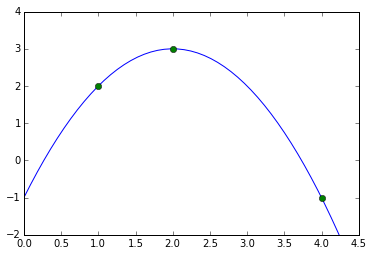

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
xs = np.linspace(0,4.4)
ys = newton_p(xs)
plt.plot(xs,ys)
x_data = [1,2,4]
y_data = [2,3,-1]
plt.plot(x_data,y_data,'o')
ax = plt.gca()
ax.set_ylim(-2,4)

## Implementation
### Lagrange form
The `scipy.interpolate` package has a `lagrange` command that returns a `poly1d` object interpolating the points. As we will see, the Lagrange polynomial is not such a good idea for large data sets, but it's important theoretically

In [4]:
from scipy.interpolate import lagrange
x_data = [1,2,4]
y_data = [2,3,-1]
p = lagrange(x_data,y_data)
p

poly1d([-1.,  4., -1.])

Those are the coefficients from highest degree to lowest wrapped in a `poly1d` constructor that specifies a polynomial. Largely, we can treat it as a function:

In [5]:
p(x_data)

array([ 2.,  3., -1.])

The code implementing `lagrange` looks something like so:

In [6]:
def my_lagrange(xs,ys):
    n = len(xs)
    p = np.poly1d(0.0)
    for j in range(n):
        current = np.poly1d(ys[j])
        for k in range(n):
            if k != j:
                current = current*np.poly1d([1,-xs[k]])/(xs[j]-xs[k])
        p = p + current
    return p
my_p = my_lagrange(x_data,y_data)
my_p(x_data)

array([ 2.,  3., -1.])

### A little more on the `poly1d` class

The `poly1d` class also has a few built in methods that you can list via `dir(p)` or via tab-completion. For example, we can compute the derivative.

In [7]:
p.deriv()

poly1d([-2.,  4.])

Or, we can run NumPy's `root` command.

In [8]:
np.roots(p)

array([ 3.73205081,  0.26794919])

### Newton's form

We could just as easily implement the Newton form:

In [9]:
def newton_poly(xs,ys):
    n = len(xs)
    p = np.poly1d(ys[0])
    for k in range(n):
        prod = np.poly1d(1)
        for j in range(k):
            prod = prod*np.poly1d([1,-xs[j]])
        c = (ys[k]-p(xs[k]))/prod(xs[k])
        p = p + c*prod
    return p
newton_poly([1,2,4],[2,3,-1])

poly1d([-1.,  4., -1.])

### Horner form
The nested version of Newton's form is related to a general form for polynomials called Horner's form, which is generally faster and less error prone than standard form.

We can ask SymPy to put a polynomial in Horner form for us.

In [10]:
from sympy import horner, symbols
x = symbols('x')
horner(4*x**3+3*x**2+2*x+1)

x*(x*(4*x + 3) + 2) + 1

In [11]:
from random import randint, seed
seed(1)
poly = sum([randint(-5,5)*x**n for n in range(10)])
poly

x**9 + 5*x**8 + 2*x**7 + 2*x**6 + 2*x**5 - 4*x**4 - x**3 - 4*x**2 + 4*x - 3

In [12]:
horner(poly)

x*(x*(x*(x*(x*(x*(x*(x*(x + 5) + 2) + 2) + 2) - 4) - 1) - 4) + 4) - 3

NumPy automatically uses Horner form when evaluating a polynomial.

## Error in interpolation
### An example

Suppose we want to approximate a non-polynomial function with an interpolating polynomial. It turns out that the interpolating polynomial is guaranteed to go through the specified points but might vary widely between them.  Here's an example illustrating this.

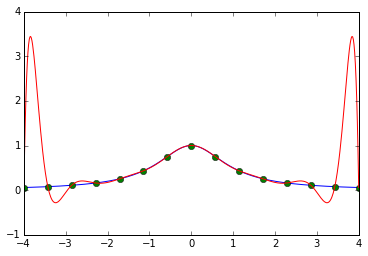

In [13]:
def f(x): return 1/(1+x**2)
x_data = np.linspace(-4,4,15)
y_data = f(x_data)
p = lagrange(x_data,y_data)
xs = np.linspace(-4,4,500)
ys = f(xs)
plt.plot(xs,ys)
plt.plot(x_data,y_data,'o')
ys = p(xs)
plt.plot(xs,ys)
ax = plt.gca()
ax.set_ylim(-1,4);

We can do better, though, using the so called Chebyshev nodes.

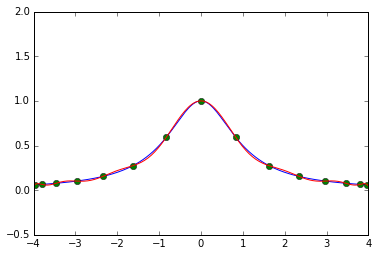

In [14]:
n = 14
x_data = np.array([4*np.cos(np.pi*(2*i+1)/(2*n+2)) for i in range(0,n+1)])
y_data = f(x_data)
p = lagrange(x_data,y_data)
xs = np.linspace(-4,4,200)
ys = f(xs)
plt.plot(xs,ys)
plt.plot(x_data,y_data,'o')
ys = p(xs)
plt.plot(xs,ys)
ax = plt.gca()
ax.set_ylim(-0.5,2);

### The error bound

Suppose that $f$ is $n+1$ times differentiable on $[a,b]$ and that $p$ is a polynomial of degree at most $n$ that interpolates $f$ at the $n+1$ distinct nodes $x_0,x_1,\ldots,x_n$ in $[a,b]$. Then for each $x \in [a,b]$ there is some $\xi\in[a,b]$ such that
$$f(x) = p(x) + \frac{1}{(n+1)!} f^{(n+1)}(\xi) \prod_{i=0}^n (x-x_i).$$
This is remarkably similar to Taylor's remainder theorem. In fact, in the limit as each $x_i\to x_0$, it is *exactly* Taylors remainder theorem!

The Chebyshev nodes on $[-1,1]$ have the remarkable property that 
$$\left|{\prod_{i=0}^n (t-x_i)}\right| \le 2^{-n}$$
for any $t \in [-1,1].$  Moreover, it can be shown that for *any*
choice of nodes $x_i$ that
$$\max_{t\in[-1,1]} \left|\prod_{i=0}^n (t-x_i)\right| \ge 2^{-n}.$$
Thus the Chebyshev nodes are considered the best for polynomial
interpolation.
